# Continous Assessment - 2

### Transportation Sector
##### Aviation

It is critical that Irish aviation practices and procedures comply with best international standards; promoting the development of a vibrant, competitive and progressively regulated aviation sector and the provision of adequate airport infrastructure and competitive airport services.

##### Ireland's aviation policy is centred around three main aims:

- To enhance Ireland’s connectivity by ensuring safe, secure and competitive access responsive to the needs of business, tourism and consumers.
- To foster the growth of aviation enterprise in Ireland to support job creation and position Ireland as a recognised global leader in aviation.
- To maximise the contribution of the aviation sector to Ireland’s economic growth and development

In [48]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import randint
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge

# Define filenames
ireland_dataset_filename1 = 'TAA02.20240102175208.csv'
ireland_dataset_filename2 = 'TAA03.20240102175407.csv'

# Load Ireland datasets efficiently with specified data types and necessary columns
dtypes_ireland = { 'C02191V03548': 'category', 'C02191V04000': 'category', 'STATISTIC': 'category', 'Statistic Label': 'category', 'TLIST(A1)': 'category', 'C02935V03550': 'category', 'C02354V02832': 'category', 'C02936V03551': 'category' }
columns_to_use_ireland = ['YEAR', 'MONTH', 'VALUE']  # Include only relevant columns

ireland_dataset_1 = pd.read_csv(ireland_dataset_filename1, dtype=dtypes_ireland, usecols=columns_to_use_ireland)
ireland_dataset_2 = pd.read_csv(ireland_dataset_filename2, dtype=dtypes_ireland, usecols=columns_to_use_ireland)

# Combine Ireland datasets
combined_ireland_dataset = pd.concat([ireland_dataset_1, ireland_dataset_2], ignore_index=True)

# Load LA dataset using Socrata client
client = Socrata("data.lacity.org", None)
results = client.get("d3a2-7j6v", limit=2000)
la_flights_dataset = pd.DataFrame.from_records(results)

# Optimize data types for LA dataset
dtypes_la = { 'reportperiod': 'str', 'passenger_count': 'int32' }
la_flights_dataset = la_flights_dataset.astype(dtypes_la)

# Convert 'reportperiod' to datetime and extract month and year
la_flights_dataset['reportperiod'] = pd.to_datetime(la_flights_dataset['reportperiod'])
la_flights_dataset['month'] = la_flights_dataset['reportperiod'].dt.month.astype('int8')
la_flights_dataset['year'] = la_flights_dataset['reportperiod'].dt.year.astype('int16')

# Data Engineering for Ireland Dataset
combined_ireland_dataset['value'] = combined_ireland_dataset['value'].astype('float32')
combined_ireland_dataset['passenger_millions'] = combined_ireland_dataset['value'] / 1000

# Min-Max Normalization
scaler = MinMaxScaler()
ireland_passenger_values = combined_ireland_dataset['passenger_millions'].values.reshape(-1, 1)
la_passenger_values = la_flights_dataset['passenger_count'].values.reshape(-1, 1)

scaler.fit(ireland_passenger_values)
combined_ireland_dataset['scaled_passenger_millions'] = scaler.transform(ireland_passenger_values)
la_flights_dataset['scaled_passenger_count'] = scaler.transform(la_passenger_values) / 1_000_000

# Clean up to free memory
del ireland_dataset_1, ireland_dataset_2, ireland_passenger_values, la_passenger_values

LA Flights Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DataExtractDate         2011 non-null   object        
 1   ReportPeriod            2011 non-null   datetime64[ns]
 2   Arrival_Departure       2011 non-null   object        
 3   Domestic_International  2011 non-null   object        
 4   FlightType              2011 non-null   object        
 5   Passenger_Count         2011 non-null   int32         
 6   Month                   2011 non-null   int8          
 7   Year                    2011 non-null   int16         
 8   Scaled Passenger Count  2011 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int16(1), int32(1), int8(1), object(4)
memory usage: 108.1+ KB

LA Flights Dataset Describe:
       Passenger_Count        Month         Year  Scaled Passenger Count
coun

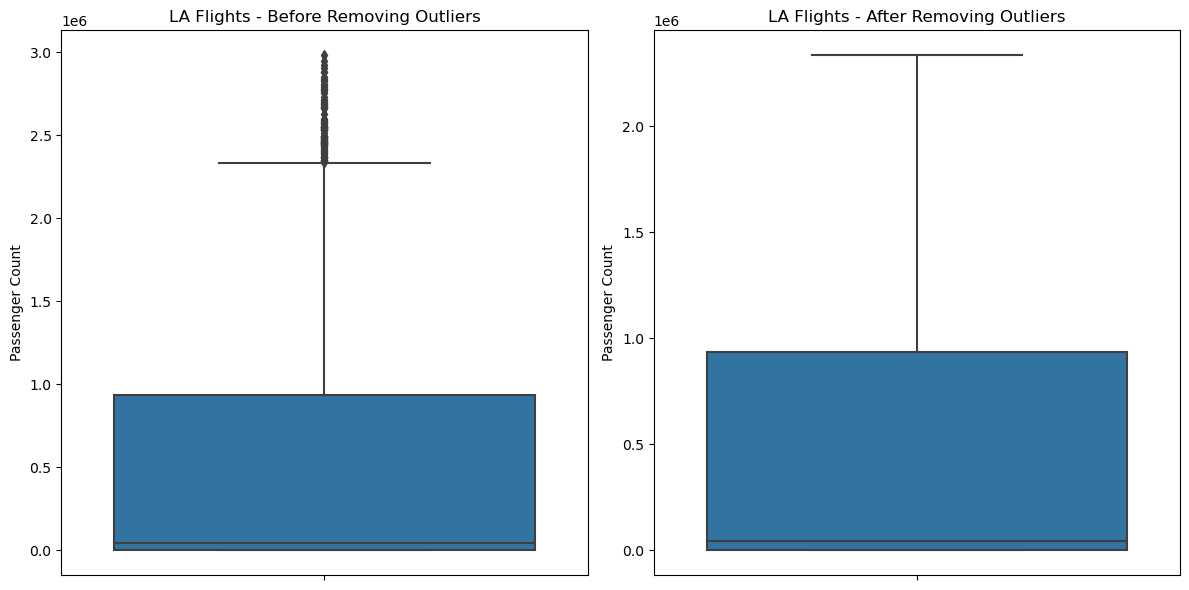

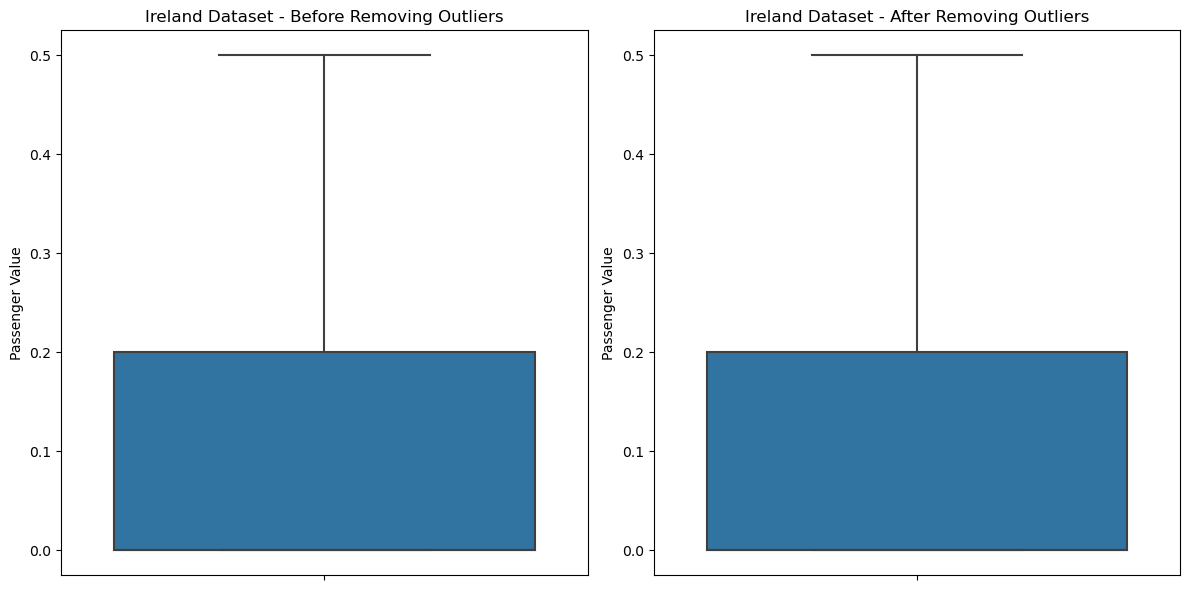

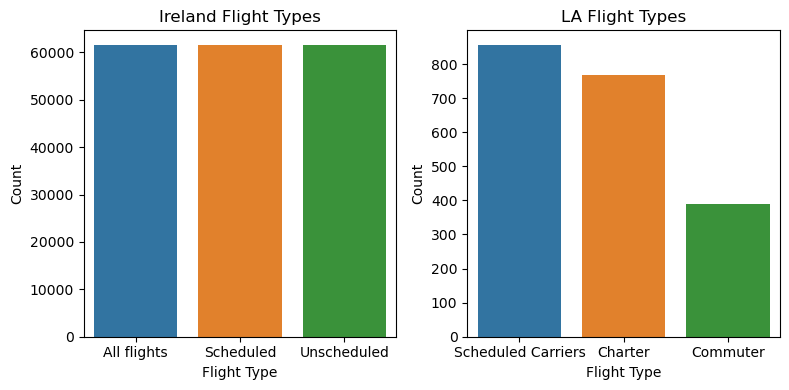

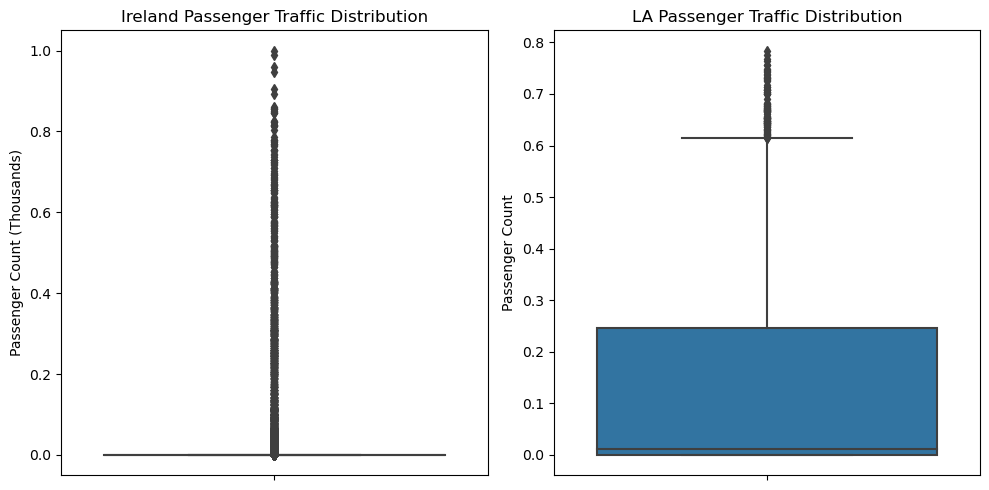

In [50]:
# 1. Efficient EDA
# It's more efficient to view the info and describe outputs directly rather than storing them in variables
print("LA Flights Dataset Info:")
la_flights_dataset.info()

print("\nLA Flights Dataset Describe:")
print(la_flights_dataset.describe())

print("\nIreland Dataset Info:")
combined_ireland_dataset.info()

print("\nIreland Dataset Describe:")
print(combined_ireland_dataset.describe())

# 2. Identifying and Addressing Outliers
# Using .clip() method for efficiency
lower_bound_la, upper_bound_la = la_flights_dataset['Passenger_Count'].quantile([0.25, 0.75])
IQR_la = upper_bound_la - lower_bound_la
la_flights_filtered = la_flights_dataset.copy()
la_flights_filtered['Passenger_Count'] = la_flights_filtered['Passenger_Count'].clip(lower=lower_bound_la - 1.5 * IQR_la, upper=upper_bound_la + 1.5 * IQR_la)

# Similar process for Ireland dataset
ireland_filtered = combined_ireland_dataset.copy()
lower_bound_ireland, upper_bound_ireland = combined_ireland_dataset['VALUE'].quantile([0.25, 0.75])
IQR_ireland = upper_bound_ireland - lower_bound_ireland
ireland_filtered['VALUE'] = ireland_filtered['VALUE'].clip(lower=lower_bound_ireland - 1.5 * IQR_ireland, upper=upper_bound_ireland + 1.5 * IQR_ireland)

# 3. Efficient Boxplot Visualization
plt.figure(figsize=(12, 6))

# Boxplot for LA Flights Dataset - Before and After Removing Outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=la_flights_dataset['Passenger_Count'])
plt.title('LA Flights - Before Removing Outliers')
plt.ylabel('Passenger Count')

plt.subplot(1, 2, 2)
sns.boxplot(y=la_flights_filtered['Passenger_Count'])
plt.title('LA Flights - After Removing Outliers')
plt.ylabel('Passenger Count')
plt.tight_layout()

# Similar boxplot for Ireland dataset
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=ireland_filtered['VALUE'])
plt.title('Ireland Dataset - Before Removing Outliers')
plt.ylabel('Passenger Value')

plt.subplot(1, 2, 2)
sns.boxplot(y=ireland_filtered['VALUE'])
plt.title('Ireland Dataset - After Removing Outliers')
plt.ylabel('Passenger Value')
plt.tight_layout()

plt.show()

# Efficient Aggregation and Visualization
# Aggregating LA data on a yearly basis
la_yearly = la_flights_filtered.groupby('Year')['Scaled Passenger Count'].mean()

# Aggregating Ireland data on a yearly basis
ireland_yearly = ireland_filtered.groupby('Year')['Scaled Passenger Millions'].mean()

# Creating a combined DataFrame for comparison
combined_yearly = pd.DataFrame({
    'year': ireland_yearly.index,
    'Passengers_Ireland': ireland_yearly.values,
    'Passengers_LA': la_yearly.values 
})

# Plotly Line Chart for Yearly Comparison
fig = px.line(combined_yearly, x='year', y=['Passengers_Ireland', 'Passengers_LA'],
              labels={'value': 'Total Passengers', 'variable': 'Location'},
              title='Yearly Passenger Trends Comparison: Ireland vs LA (Scaled)')
fig.show()

# 6. Efficient Categorical Data Analysis
# Summarizing and plotting flight types for both datasets
ireland_flight_type = ireland_filtered['Flight Type'].value_counts()
la_flight_type = la_flights_filtered['FlightType'].value_counts()

plt.figure(figsize=(8, 4))

# Ireland Flight Types
plt.subplot(1, 2, 1)
sns.barplot(x=ireland_flight_type.index, y=ireland_flight_type.values)
plt.title('Ireland Flight Types')
plt.xlabel('Flight Type')
plt.ylabel('Count')

# LA Flight Types
plt.subplot(1, 2, 2)
sns.barplot(x=la_flight_type.index, y=la_flight_type.values)
plt.title('LA Flight Types')
plt.xlabel('Flight Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Visualizing Scaled Passenger Traffic
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=ireland_filtered['Scaled Passenger Millions'])
plt.title('Ireland Passenger Traffic Distribution')
plt.ylabel('Passenger Count (Thousands)')

plt.subplot(1, 2, 2)
sns.boxplot(y=la_flights_filtered['Scaled Passenger Count']*10)
plt.title('LA Passenger Traffic Distribution')
plt.ylabel('Passenger Count')

plt.tight_layout()
plt.show()

# Flight Type Distribution in Ireland
fig = px.bar(ireland_flight_type, title='Flight Type Distribution in Ireland')
fig.show()

In [45]:
# STATISTIC ANALYSIS

# For Ireland - Confidence Interval calculation for top countries
top_countries = ireland_filtered['Country'].value_counts().head(5).index
confidence_intervals_ireland = {}
z_score = stats.norm.ppf(0.975)  # for a 95% confidence level

for country in top_countries:
    country_data = ireland_filtered[ireland_filtered['Country'] == country]['Scaled Passenger Millions']
    mean, std_error = np.mean(country_data), stats.sem(country_data, nan_policy='omit')
    margin_of_error = z_score * std_error
    confidence_intervals_ireland[country] = (mean - margin_of_error, mean + margin_of_error)

# For LA - Confidence Interval calculation for flight types
flight_types = ['Domestic', 'International']
confidence_intervals_la = {}

for flight_type in flight_types:
    flight_data = la_flights_dataset[la_flights_dataset['Domestic_International'] == flight_type]['Scaled Passenger Count']
    mean, std_error = np.mean(flight_data), stats.sem(flight_data, nan_policy='omit')
    margin_of_error = z_score * std_error
    confidence_intervals_la[flight_type] = (mean - margin_of_error, mean + margin_of_error)

# ANOVA for yearly trends in flight traffic - Ireland
anova_model_ireland = ols('VALUE ~ C(Year)', data=ireland_filtered).fit()
anova_results_ireland = sm.stats.anova_lm(anova_model_ireland, typ=2)

# ANOVA for differences in passenger count among flight types - LA
anova_model_la = ols('Passenger_Count ~ C(FlightType)', data=la_flights_dataset).fit()
anova_results_la = sm.stats.anova_lm(anova_model_la, typ=2)

# Chi-Squared Test for Ireland: 'Flight Type' vs 'Direction'
contingency_table_ireland = pd.crosstab(ireland_filtered['Flight Type'], ireland_filtered['Direction'])
chi2_ireland, p_ireland, dof_ireland, expected_ireland = chi2_contingency(contingency_table_ireland)

# Chi-Squared Test for LA: 'Domestic_International' vs 'Arrival_Departure'
contingency_table_la = pd.crosstab(la_flights_dataset['Domestic_International'], la_flights_dataset['Arrival_Departure'])
chi2_la, p_la, dof_la, expected_la = chi2_contingency(contingency_table_la)

# Independent Samples T-Test - Comparison between 2010 and 2015 for Ireland
data_2010_ireland = ireland_filtered[ireland_filtered['Year'] == 2010]['VALUE']
data_2015_ireland = ireland_filtered[ireland_filtered['Year'] == 2015]['VALUE']
t_stat_ireland, p_value_ireland = stats.ttest_ind(data_2010_ireland, data_2015_ireland, equal_var=False)

# Independent Samples T-Test - Comparison between 2010 and 2015 for LA
data_2010_la = la_flights_dataset[la_flights_dataset['Year'] == 2010]['Passenger_Count']
data_2015_la = la_flights_dataset[la_flights_dataset['Year'] == 2015]['Passenger_Count']
t_stat_la, p_value_la = stats.ttest_ind(data_2010_la, data_2015_la, equal_var=False)

# One-Sample T-Test for LA - 2010 vs Hypothesized Mean
hypothesized_mean_la = 600000  # example value
t_stat_one_sample_la, p_value_one_sample_la = stats.ttest_1samp(data_2010_la, hypothesized_mean_la)

# Wilcoxon Signed-Rank Test for LA - Comparison between 2018 and 2019
data_2018_la = la_flights_dataset[la_flights_dataset['Year'] == 2018]['Passenger_Count']
data_2019_la = la_flights_dataset[la_flights_dataset['Year'] == 2019]['Passenger_Count']
min_length_la = min(len(data_2018_la), len(data_2019_la))
data_2018_la_sampled = data_2018_la.sample(n=min_length_la, random_state=1)
data_2019_la_sampled = data_2019_la.sample(n=min_length_la, random_state=1)
w_stat_la, p_value_wilcoxon_la = stats.wilcoxon(data_2018_la_sampled, data_2019_la_sampled)

# Store the results in a dictionary for easy access and display
results = {
    'Confidence Intervals Ireland': confidence_intervals_ireland,
    'Confidence Intervals LA': confidence_intervals_la,
    'ANOVA Ireland': anova_results_ireland,
    'ANOVA LA': anova_results_la,
    'Chi-Squared Ireland': (chi2_ireland, p_ireland, dof_ireland, expected_ireland),
    'Chi-Squared LA': (chi2_la, p_la, dof_la, expected_la),
    'T-Test Ireland': (t_stat_ireland, p_value_ireland),
    'T-Test LA': (t_stat_la, p_value_la),
    'One-Sample T-Test LA': (t_stat_one_sample_la, p_value_one_sample_la),
    'Wilcoxon Test LA': (w_stat_la, p_value_wilcoxon_la)
}

# Display results
for key, value in results.items():
    print(f"{key}: \n{value}\n")


Confidence Intervals Ireland: 
{'All Countries': (0.028981742844813526, 0.037331896438366714), 'Canada': (0.00021301671018591055, 0.0003006981444195854), 'England': (0.00993591878784514, 0.012715593387953276), 'Northern Ireland': (2.3881827988467025e-05, 3.504256204372194e-05), 'Ireland (domestic)': (0.0007112101504108933, 0.0010018025439702842)}

Confidence Intervals LA: 
{'Domestic': (0.018866492537783275, 0.021929902320981673), 'International': (0.00868927549481021, 0.010103826873445687)}

ANOVA Ireland: 
               sum_sq        df          F        PR(>F)
C(Year)     13.401590      17.0  18.008141  6.820136e-55
Residual  8088.537308  184770.0        NaN           NaN

ANOVA LA: 
                     sum_sq      df            F  PR(>F)
C(FlightType)  8.821102e+14     2.0  1990.074119     0.0
Residual       4.450280e+14  2008.0          NaN     NaN

Chi-Squared Ireland: 
(0.0, 1.0, 4, array([[20532., 20532., 20532.],
       [20532., 20532., 20532.],
       [20532., 20532., 20532

In [ ]:
#MACHINE LEARNING BULDING AND TRAINING

# Dropping unnecessary columns
ireland_cleaned = ireland_filtered.drop(columns=["UNIT"])

# Aggregating data by year
data_yearly = ireland_cleaned.groupby(['Year', 'Airports in Ireland', 'Country', 'Direction', 'Flight Type']).agg({'VALUE': 'sum', 'Passenger Millions': 'sum', 'Scaled Passenger Millions': 'sum'}).reset_index()

# Encoding categorical variables
encoder = OneHotEncoder(sparse_output=True)  # Use sparse_output for memory efficiency
encoded_columns = encoder.fit_transform(data_yearly[['Airports in Ireland', 'Country', 'Direction', 'Flight Type']])
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_columns, columns=encoder.get_feature_names_out())

# Merging the encoded columns with the original data
data_prepared = pd.concat([data_yearly, encoded_df], axis=1).drop(['Airports in Ireland', 'Country', 'Direction', 'Flight Type'], axis=1)

# Defining the features and target variable
X = data_prepared.drop(['VALUE', 'Passenger Millions', 'Scaled Passenger Millions'], axis=1)
y = data_prepared['Passenger Millions']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "Neural Network": MLPRegressor(random_state=42)
}

# Function to train and evaluate models
def train_evaluate_models(models, X_train, y_train, X_test, y_test):
    model_performance = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse, mae = mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)
        model_performance[model_name] = {'MSE': mse, 'RMSE': np.sqrt(mse), 'MAE': mae}
    return model_performance

model_performance = train_evaluate_models(models, X_train, y_train, X_test, y_test)

# Hyperparameter tuning for Gradient Boosting Regressor
param_grid_gbr = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]}
grid_search_gbr = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid=param_grid_gbr, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_gbr.fit(X_train, y_train)
best_params_gbr, best_score_gbr = grid_search_gbr.best_params_, grid_search_gbr.best_score_

# Hyperparameter tuning for Random Forest Regressor
param_distributions_rfr = {'n_estimators': randint(100, 1000), 'max_depth': randint(10, 100), 'min_samples_split': randint(2, 20), 'min_samples_leaf': randint(1, 20)}
random_search_rfr = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_distributions_rfr, n_iter=5, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search_rfr.fit(X_train, y_train)
best_params_rfr, best_score_rfr = random_search_rfr.best_params_, random_search_rfr.best_score_

# Hyperparameter tuning for Neural Network with Pipeline
pipeline_nn = Pipeline([('scaler', StandardScaler()), ('nn', MLPRegressor(random_state=42))])
param_grid_nn = {'nn__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], 'nn__activation': ['tanh', 'relu'], 'nn__solver': ['sgd', 'adam'], 'nn__alpha': [0.0001, 0.05], 'nn__learning_rate': ['constant','adaptive']}
grid_search_nn = GridSearchCV(pipeline_nn, param_grid=param_grid_nn, n_jobs=-1, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search_nn.fit(X_train, y_train)
best_params_nn, best_score_nn = grid_search_nn.best_params_, grid_search_nn.best_score_

# Predicting with the best estimator from Neural Network
y_pred_nn = grid_search_nn.predict(X_test)
mse_nn, rmse_nn, mae_nn = mean_squared_error(y_test, y_pred_nn), np.sqrt(mean_squared_error(y_test, y_pred_nn)), mean_absolute_error(y_test, y_pred_nn)

# Bokeh Visualization
output_notebook()

# Data
models = ['Random Forest', 'Gradient Boosting', 'Neural Network']
tuning = ['Before Tuning', 'After Tuning']
metrics = ['MSE', 'RMSE', 'MAE']
data = {'models': models,
        'MSE_Before': [5.612700496991892e-09, 1.339954113112935e-08, 0.42458051830968135],
        'MSE_After': [6.205090760614536e-09, 9.765209701455155e-09, 0.0020245364790739497],
        'RMSE_Before': [7.491795844116344e-05, 0.0001157563869992898, 0.651598433323532],
        'RMSE_After': [7.877239846935306e-05, 9.881907559502444e-05, 0.04499484947273354],
        'MAE_Before': [3.328154154677827e-05, 7.481326086241598e-05, 0.6503566495043961],
        'MAE_After': [3.802027503408869e-05, 6.10729539431655e-05, 0.04487710380099862]}

# Preparing the data
source = ColumnDataSource(data=data)

# Creating the plot
p = figure(x_range=models, outer_height=350, title="Model Performance Metrics Before and After Tuning",
           toolbar_location=None, tools="")

width = 0.2
for idx, metric in enumerate(metrics):
    p.vbar(x=dodge('models', -0.25 + idx * width, range=p.x_range), top=f'{metric}_Before', width=width, 
           source=source, color="#718dbf", legend_label=f'{metric} Before')
    p.vbar(x=dodge('models', -0.05 + idx * width, range=p.x_range), top=f'{metric}_After', width=width, 
           source=source, color="#e84d60", legend_label=f'{metric} After')

p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)